In [1]:
import numpy as np
import requests
import pandas as pd
import datetime
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize': (11, 4)})
import locale
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

'pt_BR.UTF-8'

In [2]:
DOWNLOADS_FOLDER = 'data/downloaded'
EXPORTS_FOLDER = 'data/exported'
Path(DOWNLOADS_FOLDER).mkdir(parents=True, exist_ok=True)

In [3]:
font = {'fontname':'Noto Mono'}
plt.rc('font', **{'family':'Noto Mono'})

In [11]:
frames = []
for p in Path(DOWNLOADS_FOLDER).glob('*.xls'):
    try:
        df = pd.read_excel(p, skiprows=2)
    except Exception as e:
        print(p, e)
    frames.append(df)

df = pd.concat(frames)

data/downloaded/02FEV2021.xls 
data/downloaded/29FEV2021.xls Unsupported format, or corrupt file: Expected BOF record; found b'<!DOCTYP'
data/downloaded/10FEV2021.xls 


In [12]:
df.Data.max()

Timestamp('2021-06-16 00:00:00')

In [13]:
df.head()

,Data,Tipo,Area,Empresa,Linha,Passageiros Pagtes Em Dinheiro,Passageiros Comum e VT,Passageiros Pgts Bu Comum M,Passageiros Pagtes Estudante,Passageiros Pgts Bu Est Mensal,Passageiros Pgts Bu Vt Mensal,Passageiros Pagantes,Passageiros Int Ônibus->Ônibus,Passageiros Com Gratuidade,Passageiros Com Gratuidade Est,Tot Passageiros Transportados
0,2020-06-15,CONCESSAO,AREA 2,201,N40211 - METRO ITAQUERA/TERM VL CARRAO,4,28,1,0,0,0,33,16,2,0,51
1,2020-06-15,CONCESSAO,AREA 2,201,N40511 - TERM V CARRAO/METRO ITAQUERA,1,24,2,0,0,0,27,6,5,0,38
2,2020-06-15,CONCESSAO,AREA 2,201,200210 - TERM P D PEDRO II/TERM BANDEIR,22,433,43,2,0,0,500,831,253,1,1585
3,2020-06-15,CONCESSAO,AREA 2,201,210010 - TERM V CARRAO/PCA DA SE CIRC,393,2248,106,21,0,0,2768,1813,1121,4,5706
4,2020-06-15,CONCESSAO,AREA 2,201,210021 - TERM VL CARRAO/TERM PQ D PEDRO,0,2,0,0,0,0,2,0,0,0,2


In [14]:
# features
cols = {
    'Data': 'date',
    'Tipo': 'type',
    'Area': 'area',
    'Empresa': 'company',
    'Linha': 'line_name',
    'Passageiros Pagtes Em Dinheiro': 'paid_money',
    'Passageiros Comum e VT': 'paid_common_vt',
    'Passageiros Pgts Bu Comum M': 'paid_bu_common_monthly',
    'Passageiros Pagtes Estudante': 'paid_student',
    'Passageiros Pgts Bu Est Mensal': 'paid_bu_student_monthly',
    'Passageiros Pgts Bu Vt Mensal': 'paid_bu_vt_monthly',
    'Passageiros Pagantes': 'paid',
    'Passageiros Int Ônibus->Ônibus': 'integrated_bus',
    'Passageiros Com Gratuidade': 'free',
    'Passageiros Com Gratuidade Est': 'free_student',
    'Tot Passageiros Transportados': 'total_passengers'
}
df = df.rename(columns=cols)
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.day_name()
df['week'] = df['date'].dt.to_period('W')
df['month'] = df['date'].dt.to_period('M')
df['line_code'] = df.line_name.str[0:4] + '-' + df.line_name.str[4:6]

In [15]:
# filters
df = df[df.total_passengers > 0]
df.line_name.nunique()

1501

In [16]:
today = datetime.datetime.today() - datetime.timedelta(days=1)
url = f"https://www.saopaulo.sp.gov.br/wp-content/uploads/{today.strftime('%Y')}/{today.strftime('%m')}/{today.strftime('%Y%m%d')}_leitos_internacoes.csv"
# r = requests.get(url)

In [17]:
print(url)

https://www.saopaulo.sp.gov.br/wp-content/uploads/2021/06/20210616_leitos_internacoes.csv


In [18]:
df_sum = pd.read_csv(DOWNLOADS_FOLDER + f"/leitos_summary/{today.strftime('%Y%m%d')}_leitos_internacoes.csv", sep=';', encoding='utf8', decimal=',')

In [19]:
df_sum.groupby('nome_drs').size()

nome_drs
DRS 02 Araçatuba                394
DRS 03 Araraquara               394
DRS 04 Baixada Santista         394
DRS 05 Barretos                 394
DRS 06 Bauru                    394
DRS 07 Campinas                 394
DRS 08 Franca                   394
DRS 09 Marília                  394
DRS 10 Piracicaba               394
DRS 11 Presidente Prudente      394
DRS 12 Registro                 394
DRS 13 Ribeirão Preto           394
DRS 14 São João da Boa Vista    394
DRS 15 São José do Rio Preto    394
DRS 16 Sorocaba                 394
DRS 17 Taubaté                  394
Estado de São Paulo             394
Grande SP Leste                 394
Grande SP Norte                 394
Grande SP Oeste                 394
Grande SP Sudeste               394
Grande SP Sudoeste              394
Município de São Paulo          394
dtype: int64

In [20]:
df_sum['date'] = pd.to_datetime(df_sum['datahora'], format='%d/%m/%Y')

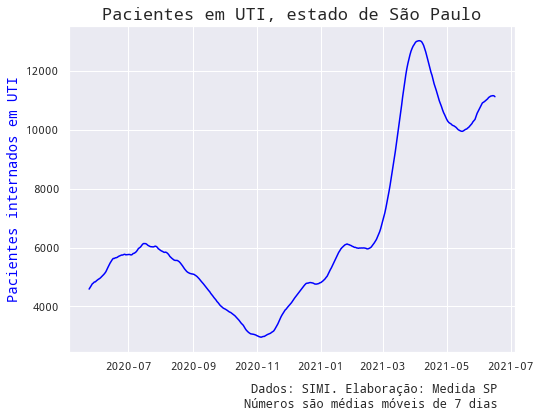

In [21]:
df_sum_state = df_sum[df_sum.nome_drs.str.contains('Estado')]

ma = 7
hosp = df_sum_state.reset_index().set_index('date').shift(0)[['pacientes_uti_ultimo_dia']].rolling(window=ma).mean()

yscale = 'linear'
# yscale = 'log'
a = 'pacientes_uti_ultimo_dia'
b = 'ocupacao_leitos'

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(8,6))
df_tmp = hosp.reset_index()
df_tmp = df_tmp[df_tmp.date >= '2020-03-15']
# make a plot
ax.plot(df_tmp.date, df_tmp[a], color="blue")
# set x-axis label
# ax.set_xlabel("Data",fontsize=14)
# set y-axis label
ax.set_ylabel("Pacientes internados em UTI",color="Blue",fontsize=14)

# # twin object for two different y-axis on the sample plot
# ax2 = ax.twinx()
# # make a plot with different y-axis using second axis object
# ax2.plot(df_tmp.date, df_tmp[b], color="blue")
# ax2.set_ylabel("Pacientes internados em UTI",color="blue",fontsize=14)

ax.set_title("Pacientes em UTI, estado de São Paulo", fontsize=17)
ax.annotate('Dados: SIMI. Elaboração: Medida SP\nNúmeros são médias móveis de 7 dias',
            xy=(0.92, 0.07), xycoords='figure fraction',
            horizontalalignment='right', verticalalignment='top',
            fontsize=12)

plt.yscale(yscale)
plt.show()


fig.savefig(f'charts/uti_sp.png', dpi=300, bbox_inches='tight')

df_tmp[['date', 'pacientes_uti_ultimo_dia']].to_csv('exports/leitos_estado.csv', index=False)

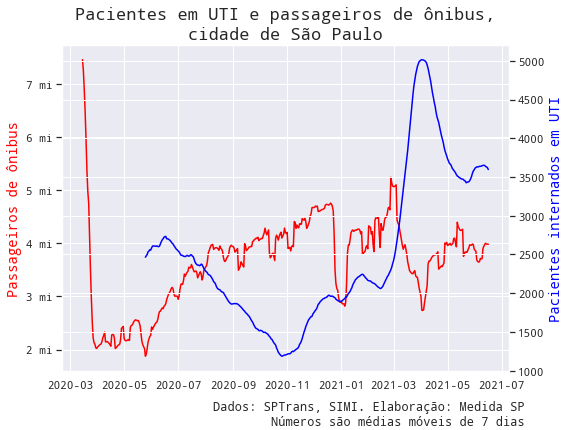

In [22]:
df_sum_state = df_sum[df_sum.nome_drs.str.contains('Município')]

ma = 7
# bus = df_line_total_daily.groupby('date').agg({'compared_to_baseline': 'mean'}).rolling(window=7).mean()
bus = df.groupby('date').agg({'total_passengers': 'sum'}).rolling(window=ma).mean()
hosp = df_sum_state.reset_index().set_index('date').shift(0)[['pacientes_uti_ultimo_dia']].rolling(window=ma).mean()

both = bus.join(hosp, how='left')

yscale = 'linear'
# yscale = 'log'
b = 'pacientes_uti_ultimo_dia'
a = 'total_passengers'

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(8,6))
df_tmp = both.reset_index()
df_tmp = df_tmp[df_tmp.date >= '2020-03-15']
# make a plot
ax.plot(df_tmp.date, df_tmp[a], color="red")
# set x-axis label
# ax.set_xlabel("Data",fontsize=14)
# set y-axis label

ax.set_ylabel("Passageiros de ônibus",color="red",fontsize=14)
ax.set_title("Pacientes em UTI e passageiros de ônibus,\ncidade de São Paulo", fontsize=17)


# twin object for two different y-axis on the sample plot
ax2 = ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df_tmp.date, df_tmp[b], color="blue")
ax2.set_ylabel("Pacientes internados em UTI",color="blue",fontsize=14)

ax.yaxis.set_major_formatter(lambda x, p: format(int(x/1000000)) + ' mi')
ax2.yaxis.set_major_formatter(lambda x, p: format(int(x/1000)) + ' mil')

ax.annotate('Dados: SPTrans, SIMI. Elaboração: Medida SP\nNúmeros são médias móveis de 7 dias',
            xy=(0.92, 0.07), xycoords='figure fraction',
            horizontalalignment='right', verticalalignment='top',
            fontsize=12)

plt.yscale(yscale)
plt.show()
fig.savefig(f'charts/passageiros_uti_sp_sp.png', dpi=300, bbox_inches='tight')

df_tmp[['date', 'pacientes_uti_ultimo_dia', 'total_passengers']].to_csv('exports/leitos_municipio.csv', index=False)

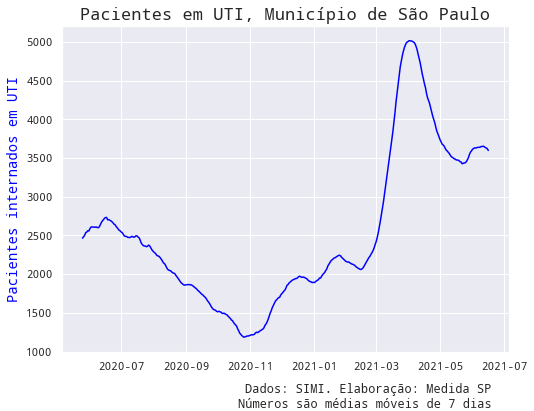

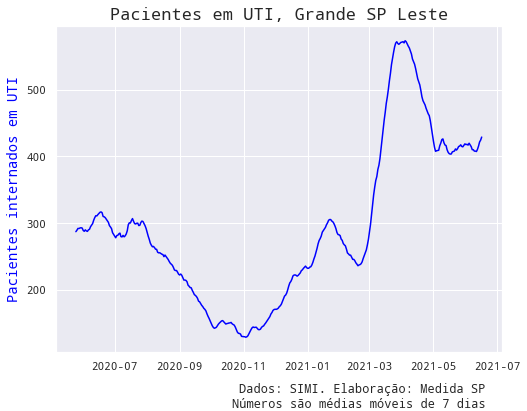

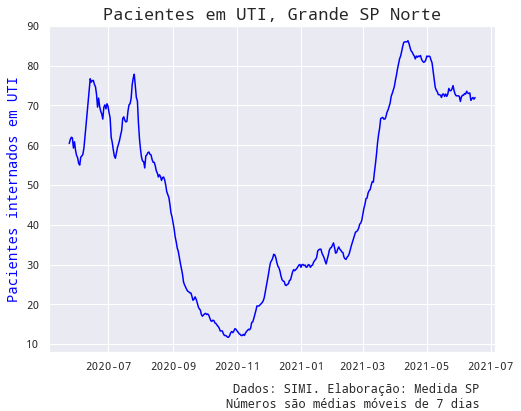

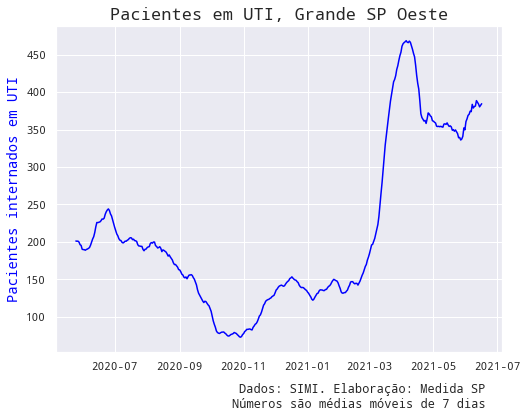

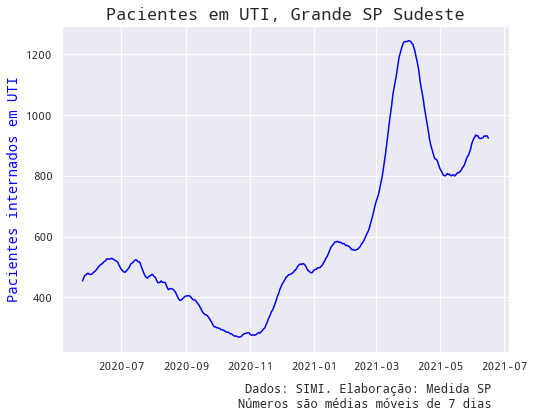

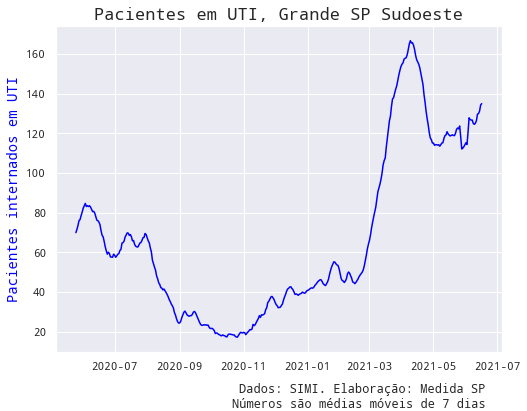

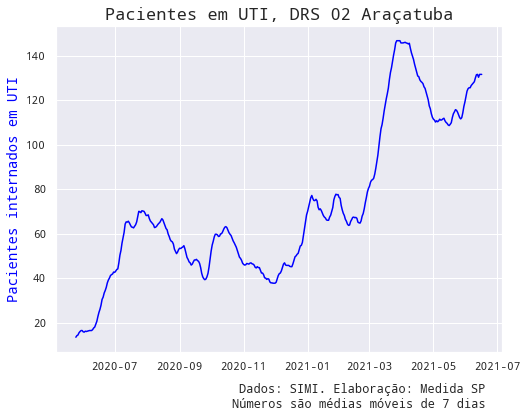

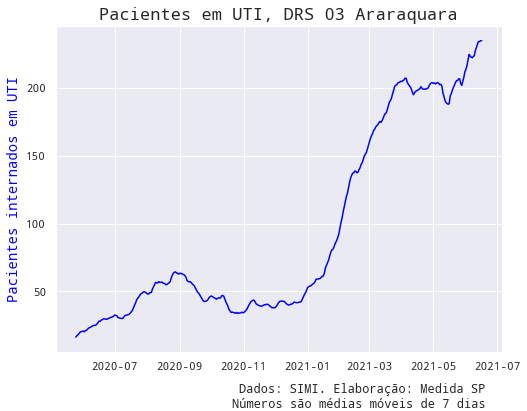

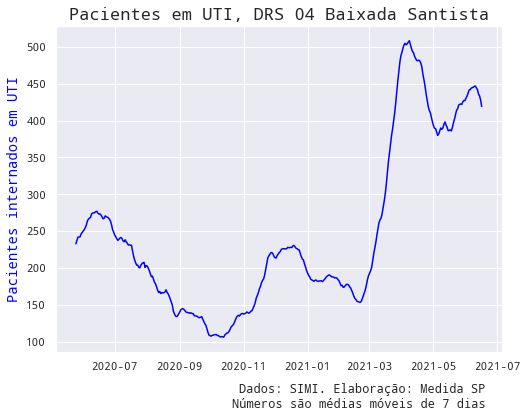

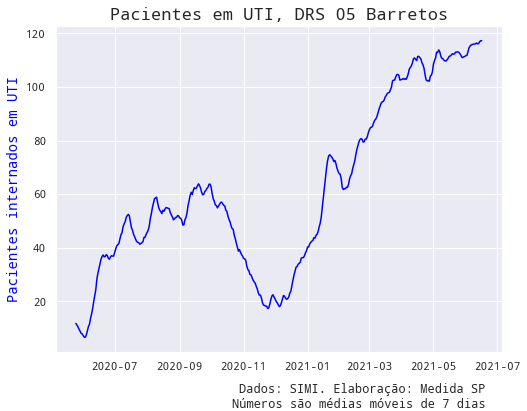

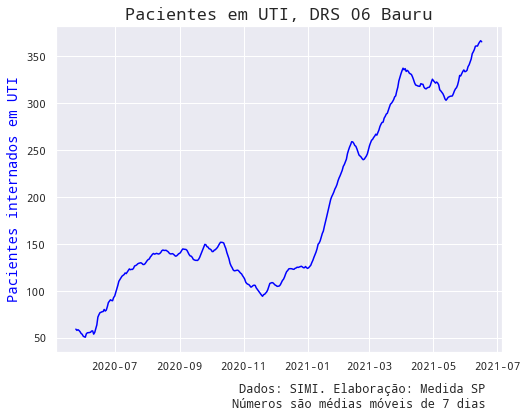

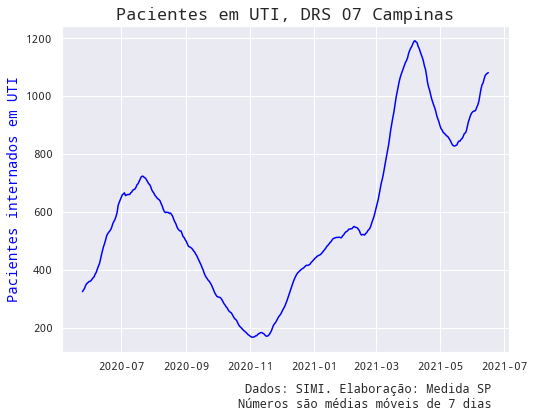

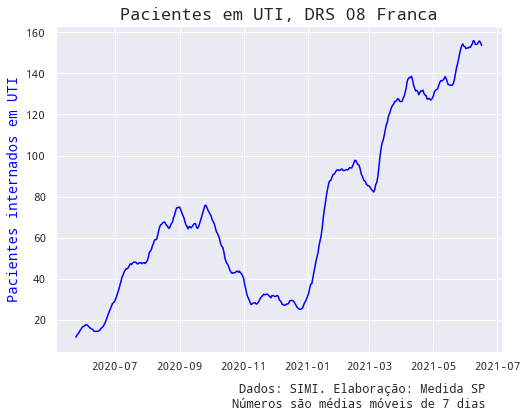

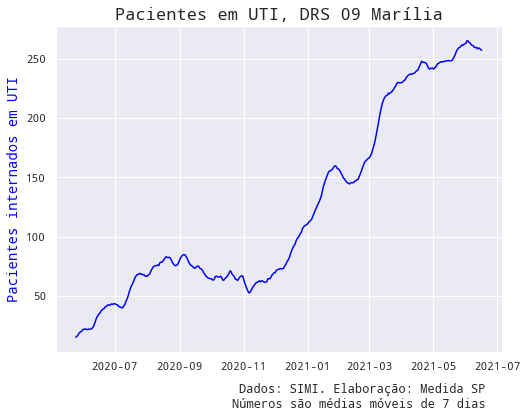

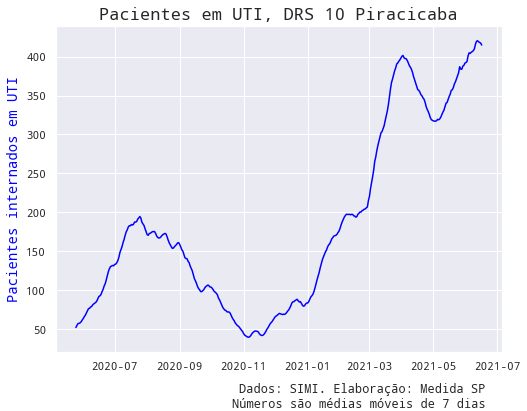

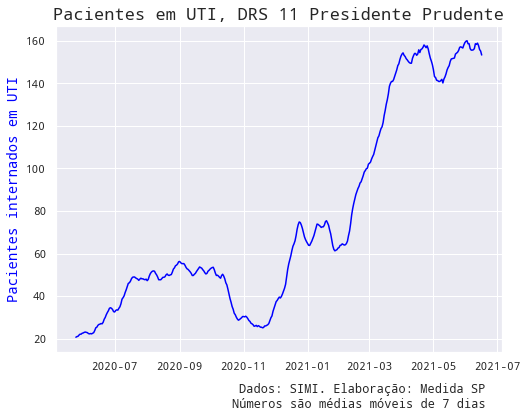

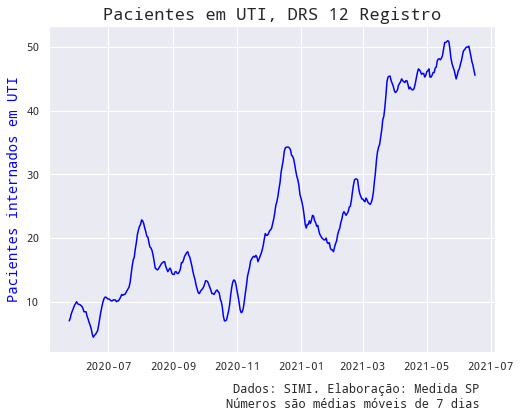

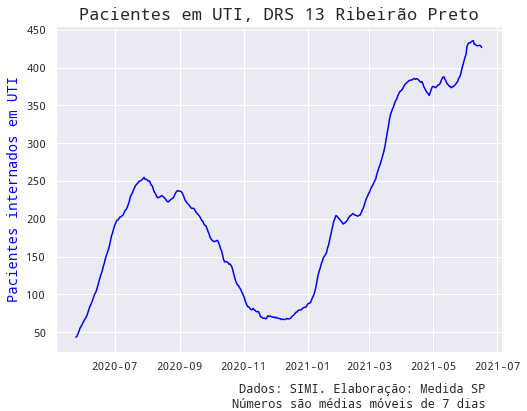

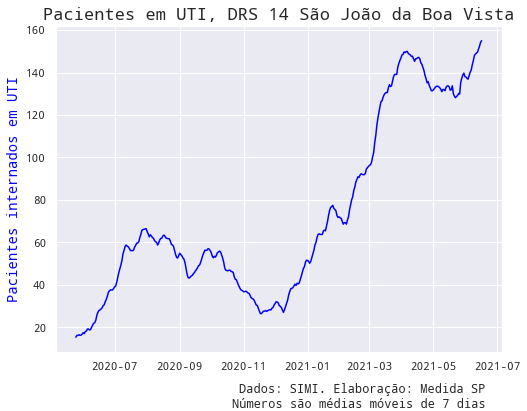

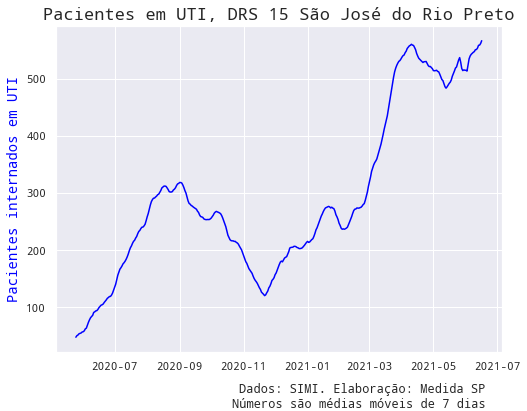

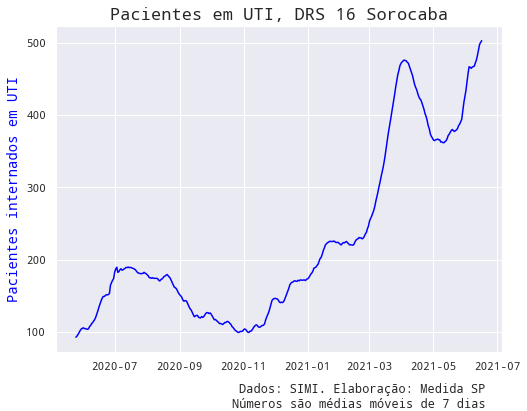

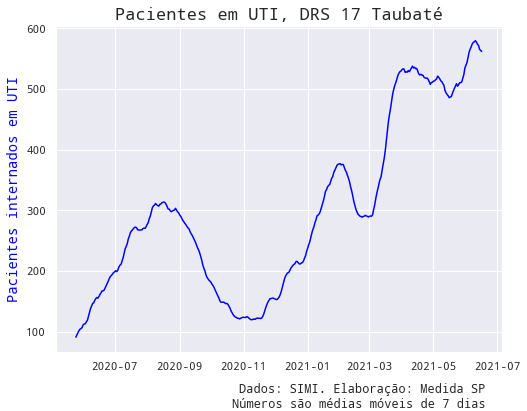

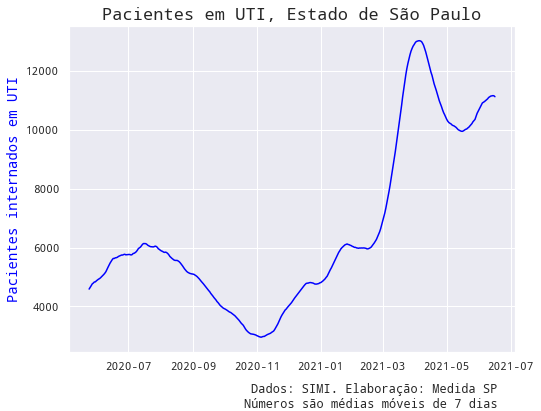

In [10]:
for drs in df_sum.nome_drs.unique():
    df_sum_state = df_sum[df_sum.nome_drs == drs]

    ma = 7
    hosp = df_sum_state.reset_index().set_index('date').shift(0)[['pacientes_uti_ultimo_dia']].rolling(window=ma).mean()

    yscale = 'linear'
    # yscale = 'log'
    a = 'pacientes_uti_ultimo_dia'
    b = 'ocupacao_leitos'

    # create figure and axis objects with subplots()
    fig,ax = plt.subplots(figsize=(8,6))
    df_tmp = hosp.reset_index()
    df_tmp = df_tmp[df_tmp.date >= '2020-03-15']
    # make a plot
    ax.plot(df_tmp.date, df_tmp[a], color="blue")
    # set x-axis label
    # ax.set_xlabel("Data",fontsize=14)
    # set y-axis label
    ax.set_ylabel("Pacientes internados em UTI",color="Blue",fontsize=14)

    # # twin object for two different y-axis on the sample plot
    # ax2 = ax.twinx()
    # # make a plot with different y-axis using second axis object
    # ax2.plot(df_tmp.date, df_tmp[b], color="blue")
    # ax2.set_ylabel("Pacientes internados em UTI",color="blue",fontsize=14)

    ax.set_title(f"Pacientes em UTI, {drs}", fontsize=17)
    ax.annotate('Dados: SIMI. Elaboração: Medida SP\nNúmeros são médias móveis de 7 dias',
                xy=(0.92, 0.07), xycoords='figure fraction',
                horizontalalignment='right', verticalalignment='top',
                fontsize=12)

    plt.yscale(yscale)
    plt.show()

In [23]:
l = pd.read_csv(DOWNLOADS_FOLDER + '/esus/esus-vepi.LeitoOcupacao.csv')

/home/bpl/programming/sptrans-passengers-analysis/sptrans/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [25]:
l.iloc[0]

_id                                    p5Ez41Zu6B
dataNotificacao          2020-04-14T03:00:00.000Z
cnes                                      2303167
ocupacaoSuspeitoCli                             0
ocupacaoSuspeitoUti                             0
ocupacaoConfirmadoCli                           0
ocupacaoConfirmadoUti                           0
saidaSuspeitaObitos                             0
saidaSuspeitaAltas                              0
saidaConfirmadaObitos                           0
saidaConfirmadaAltas                            0
origem                              aplicacao-web
_p_usuario                       _User$auVMjEVEVz
estadoNotificacao                  Santa Catarina
municipioNotificacao                      Itapema
estado                             Santa Catarina
municipio                                 Itapema
excluido                                     True
validado                                    False
_created_at              2020-04-15T13:44:30.085Z


In [35]:
l['ts'] = pd.to_datetime(l['dataNotificacao'])

In [36]:
l['date'] = l['ts'].dt.date

In [53]:
l['ocupUti'] = l.ocupacaoSuspeitoUti + l.ocupacaoConfirmadoUti

<AxesSubplot:xlabel='date'>

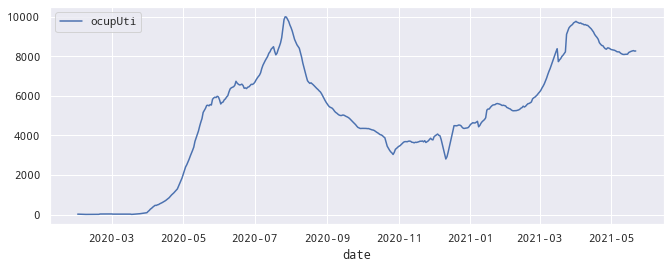

In [54]:
g = l[(l.estado == 'São Paulo') & (l['ts'] >= '2020-01-03') & (l['ts'] < '2021-05-23')].groupby('date')[['ocupUti']].sum().rolling(window=7).mean()
g.plot.line()

In [44]:
g.reset_index().sort_values('date', ascending=False).head(n=50)

,date,ocupacaoConfirmadoUti
506,2021-05-23,19737.857143
505,2021-05-22,22138.142857
504,2021-05-21,22974.428571
503,2021-05-20,23463.857143
502,2021-05-19,23606.000000
501,2021-05-18,23739.142857
500,2021-05-17,23798.285714
499,2021-05-16,23913.000000
498,2021-05-15,23852.000000
497,2021-05-14,23951.142857
